# 코드 부분

In [ ]:
import torch
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
import utils
from utils import Dataloader
import torch.nn as nn
import numpy as np
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

In [8]:
train_loader, test_loader = Dataloader()

In [22]:
'''
rnn, lstm, gru
입력 = 시퀀스(여러토큰) 
-> 각 토큰마다 히든스테이트 생성
hidden_state : 각 토큰의 상태
hidden_dim : 토큰 하나를 표현하는 벡터의 크기
hidden : 시간(step)마다의 상태 벡터
'''


class SimpleAttention(nn.Module) :
    """
    hidden_state = 
    (batch_size, sequence_length, hidden_state_dimension)
    각 토큰 하나를 몇차원으로 표현햇는지
    문맥적 의미가 반영되었다

    attnetion_mask :
    (batch_size, sequence_length)
    1 = valid_token
    0 = padding
    """
    
    def __init__(self, hidden_state_dimension) :
        super().__init__()
        self.attention_layer = nn.Linear(hidden_state_dimension, 1)

    def forward(self, hidden_state, attention_mask) :
        # attention_score : (batch_size, sequence_length)
        attention_score = self.attention_layer(hidden_state).squeeze(-1)

        # padding 위치는 점수를 -inf(무한대)로 만들어 softmax에서 0이 되게함
        attention_score = attention_score.masked_fill(attention_mask==0, float('inf'))

        # context_vector : batch_size, hidden_state_dimesion
        # 문장 하나 전체를 요약한 벡터

        attention_weights = F.softmax(attention_score, dim=1)
        # dim =1, sequence_length 각 문장안에서 토큰끼리 중요도 비교

        context_vector = torch.sum(
        attention_weights.unsqueeze(-1) * hidden_state, dim=1)

        return context_vector, attention_weights



class BiLSTMAttentionClassifier(nn.Module) :
    def __init__(
        self,
        vocabulary_size,
        embedding_dimension, # 단어 사전적 의미를 좌표로 표현
        hidden_state_dimension, # 각 단어가 이 문장안에서 어떤 역할인지
        number_of_labels,
        padding_token_id = 0,
        bidirectional=True) :

        super().__init__()

        self.embedding_layer = nn.Embedding(
            num_embeddings = vocabulary_size,
            embedding_dim = embedding_dimension,
            padding_idx = padding_token_id)

        self.bidirectional_lstm = nn.LSTM(
            input_size = embedding_dimension,
            hidden_size = hidden_state_dimension,
            batch_first = True,
            bidirectional = True)

        self.attention_layer = SimpleAttention(
            hidden_state_dimension * 2)

        self.classifier_layer = nn.Linear(
            hidden_state_dimension * 2,
            number_of_labels)


    def forward(self, input_token_ids, attention_mask) :
        '''
        input_token_ids :
        (batch_size, sequence_length)

        attention_mask :
        (batch_size, sequence_length)
        '''

        # embedded_token : (batch_size, sequence_length, embedding_dimension)
        embedded_tokens = self.embedding_layer(input_token_ids)

        # hideen_states : (batch_size, sequence_length, hidden_state_dimension*2)

        hidden_states, _ = self.bidirectional_lstm(embedded_tokens)

        # context_vector : (batch_size, hidden_state_dimension*2)
        context_vector, attention_weights = self.attention_layer(hidden_states, attention_mask)

        # logits : (batch_size, number_of_labels)
        logits = self.classifier_layer(context_vector)

        return logits

In [3]:


# 1)
def extract_labels(dataset, label_key="labels"):
    """
    StratifiedKFold용: dataset에서 샘플별 라벨을 1차원 numpy array로 추출
    """
    y = []
    for i in range(len(dataset)):
        label = dataset[i][label_key]
        # tensor → int
        if isinstance(label, torch.Tensor):
            label = label.item()
        y.append(int(label))
    return np.array(y, dtype=int)


# -------------------------
# 2) Subset 생성 함수
# -------------------------
def make_subset(dataset, indices):
    if not isinstance(indices, list):
        indices = indices.tolist()
    return Subset(dataset, indices)


# -------------------------
# 3) 1 epoch train/eval
# -------------------------
def run_one_epoch(model, loader, criterion, optimizer, device, train: bool):
    model.train() if train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        if train:
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)  # ⚠️ 네 모델 forward에 맞춰둠
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return {
        "loss": total_loss / total,
        "acc": correct / total,
        "macro_f1": f1_score(all_labels, all_preds, average="macro"),
        "weighted_f1": f1_score(all_labels, all_preds, average="weighted"),
    }


# -------------------------
# 4) ✅ 5-Fold Stratified CV ONLY
# -------------------------
def train_rnn_cv5_only(
    dataset,                 # 전체 torch Dataset
    model_fn,                # model_fn() -> nn.Module (fold마다 새 모델)
    device,
    epochs=10,
    batch_size=16,
    lr=2e-4,
    weight_decay=0.0,
    num_workers=0,
    seed=42,
):
    labels = extract_labels(train_dataset, label_key="labels")  # ✅ labels 인자 제거: 내부에서 뽑음

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(labels, labels), start=1):

        print(f"\n========== Fold {fold}/5 ==========")

        train_subset = make_subset(dataset, train_idx)
        val_subset = make_subset(dataset, val_idx)

        train_loader = utils.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        val_loader = utils.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        model = model_fn().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        best = None  # fold 내 best (val_macro_f1 기준)

        for epoch in range(1, epochs + 1):
            tr = run_one_epoch(model, train_loader, criterion, optimizer, device, train=True)
            va = run_one_epoch(model, val_loader, criterion, optimizer, device, train=False)

            print(
                f"[Fold {fold} | Epoch {epoch}] "
                f"train loss={tr['loss']:.3f} acc={tr['acc']:.3f} macroF1={tr['macro_f1']:.3f} | "
                f"val loss={va['loss']:.3f} acc={va['acc']:.3f} macroF1={va['macro_f1']:.3f}"
            )

            if (best is None) or (va["macro_f1"] > best["val_macro_f1"]):
                best = {
                    "fold": fold,
                    "best_epoch": epoch,
                    "val_loss": va["loss"],
                    "val_acc": va["acc"],
                    "val_macro_f1": va["macro_f1"],
                    "val_weighted_f1": va["weighted_f1"],
                }

        fold_results.append(best)
        print(
            f"--> Fold {fold} BEST @ epoch {best['best_epoch']}: "
            f"val_macro_f1={best['val_macro_f1']:.3f}, val_acc={best['val_acc']:.3f}, val_loss={best['val_loss']:.3f}"
        )

    # summary
    vals = {
        "val_loss": np.array([r["val_loss"] for r in fold_results], dtype=float),
        "val_acc": np.array([r["val_acc"] for r in fold_results], dtype=float),
        "val_macro_f1": np.array([r["val_macro_f1"] for r in fold_results], dtype=float),
        "val_weighted_f1": np.array([r["val_weighted_f1"] for r in fold_results], dtype=float),
    }
    summary = {k: (v.mean(), v.std(ddof=1)) for k, v in vals.items()}

    print("\n========== CV SUMMARY (mean ± std) ==========")
    for k, (m, s) in summary.items():
        print(f"{k:15s}: {m:.3f} ± {s:.3f}")

    return fold_results, summary


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = train_loader.dataset.tokenizer.vocab_size
pad_id = train_loader.dataset.tokenizer.pad_token_id

train_dataset = train_loader.dataset

def model_fn():
    return BiLSTMAttentionClassifier(
    vocabulary_size=vocab_size,
    number_of_labels = 4,
    embedding_dimension=128,
    hidden_state_dimension=256,
    bidirectional=True,
    # num_layers = 2,
    # dropout=0.1,
    padding_token_id = 0,
    # rnn_type="lstm",  # "gru"도 추천
).to(device)
   
fold_results, summary = train_rnn_cv5_only(
    dataset=train_dataset,
    model_fn=model_fn,
    device=device,
    epochs=10,
    batch_size=16,
    lr=2e-4,
)





========== Fold 1/5 ==========
[Fold 1 | Epoch 1] train loss=1.382 acc=0.267 macroF1=0.171 | val loss=1.374 acc=0.353 macroF1=0.215
[Fold 1 | Epoch 2] train loss=1.366 acc=0.333 macroF1=0.196 | val loss=1.368 acc=0.294 macroF1=0.114
[Fold 1 | Epoch 3] train loss=1.356 acc=0.393 macroF1=0.287 | val loss=1.361 acc=0.324 macroF1=0.193
[Fold 1 | Epoch 4] train loss=1.345 acc=0.467 macroF1=0.352 | val loss=1.356 acc=0.324 macroF1=0.200
[Fold 1 | Epoch 5] train loss=1.334 acc=0.496 macroF1=0.353 | val loss=1.354 acc=0.265 macroF1=0.153
[Fold 1 | Epoch 6] train loss=1.323 acc=0.489 macroF1=0.329 | val loss=1.352 acc=0.294 macroF1=0.167
[Fold 1 | Epoch 7] train loss=1.310 acc=0.422 macroF1=0.297 | val loss=1.353 acc=0.324 macroF1=0.162
[Fold 1 | Epoch 8] train loss=1.295 acc=0.437 macroF1=0.326 | val loss=1.356 acc=0.353 macroF1=0.235
[Fold 1 | Epoch 9] train loss=1.273 acc=0.415 macroF1=0.307 | val loss=1.375 acc=0.353 macroF1=0.240
[Fold 1 | Epoch 10] train loss=1.216 acc=0.444 macroF1=0.33

KeyboardInterrupt: 

In [26]:



def run_one_epoch(model, loader, criterion, optimizer, device, train: bool):
    model.train() if train else model.eval()

    total_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        if train:
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return {
        "loss": total_loss / total,
        "acc": correct / total,
        "macro_f1": f1_score(all_labels, all_preds, average="macro"),
        "weighted_f1": f1_score(all_labels, all_preds, average="weighted"),
        "y_true": all_labels,
        "y_pred": all_preds,
    }


def train_final_and_test(
    train_dataset,
    test_dataset,
    model_fn,
    device,
    epochs=5,
    batch_size=16,
    lr=2e-4,
    weight_decay=0.0,
    num_workers=0,
    seed=42,
           
):
    torch.manual_seed(seed)
    np.random.seed(seed)

   
    train_ds = train_dataset
     

    train_loader = utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader  = utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # -------------------------
    # 2) model/opt
    # -------------------------
    model = model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state = None
    best_metric = -1.0
    best_epoch = 0

    # -------------------------
    # 3) Train epochs
    # -------------------------
    train_result = {
    "train_loss": [],
    "train_acc": [],
    "macrof1": [],
}



    for epoch in range(1, epochs + 1):
        tr = run_one_epoch(model, train_loader, criterion, optimizer, device, train=True)
        train_result['train_loss'].append(round(tr['loss'], 3))
        train_result['train_acc'].append(round(tr['acc'], 3))
        train_result['macrof1'].append(round(tr['macro_f1'], 3))  
                
        print(f"[Epoch {epoch}] train loss={tr['loss']:.4f} acc={tr['acc']:.4f} macroF1={tr['macro_f1']:.4f}")



    # -------------------------
    # 5) Test evaluation (딱 1번)
    # -------------------------
    test_metrics = run_one_epoch(model, test_loader, criterion, optimizer=None, device=device, train=False)

    print("\n========== TEST RESULT ==========")
    print(f"test loss={test_metrics['loss']:.4f} acc={test_metrics['acc']:.4f} macroF1={test_metrics['macro_f1']:.4f} weightedF1={test_metrics['weighted_f1']:.4f}")

    # 상세 리포트
    print("\n[Classification Report]")
    print(classification_report(test_metrics["y_true"], test_metrics["y_pred"], digits=4))

    print("\n[Confusion Matrix]")
    print(confusion_matrix(test_metrics["y_true"], test_metrics["y_pred"]))

    return model, test_metrics, train_result


In [27]:
train_loader, test_loader = Dataloader()
train_dataset = train_loader.dataset
test_dataset = test_loader.dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = train_loader.dataset.tokenizer.vocab_size
pad_id = train_loader.dataset.tokenizer.pad_token_id


def final_model_fn():
    return BiLSTMAttentionClassifier(
    vocabulary_size=vocab_size,
    number_of_labels = 4,
    embedding_dimension=128,
    hidden_state_dimension=256,
    bidirectional=True,
    padding_token_id = 0,
).to(device)

final_model, test_metrics, train_result = train_final_and_test(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    model_fn=final_model_fn,
    device=device,
    epochs=10,
    batch_size=16,
    lr=2e-4,
    
)


[Epoch 1] train loss=1.3820 acc=0.2899 macroF1=0.1129
[Epoch 2] train loss=1.3669 acc=0.3018 macroF1=0.1330
[Epoch 3] train loss=1.3530 acc=0.3905 macroF1=0.2520
[Epoch 4] train loss=1.3413 acc=0.4615 macroF1=0.3002
[Epoch 5] train loss=1.3309 acc=0.4142 macroF1=0.2668
[Epoch 6] train loss=1.3200 acc=0.4556 macroF1=0.3170
[Epoch 7] train loss=1.3076 acc=0.4379 macroF1=0.2824
[Epoch 8] train loss=1.2873 acc=0.4142 macroF1=0.2649
[Epoch 9] train loss=1.2607 acc=0.4379 macroF1=0.3067
[Epoch 10] train loss=1.2295 acc=0.5030 macroF1=0.3803

========== TEST RESULT ==========
test loss=1.2354 acc=0.4419 macroF1=0.3213 weightedF1=0.3827

[Classification Report]
              precision    recall  f1-score   support

           0     0.7778    0.5385    0.6364        13
           1     0.2000    0.0909    0.1250        11
           2     0.3793    0.8462    0.5238        13
           3     0.0000    0.0000    0.0000         6

    accuracy                         0.4419        43
   macro avg

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

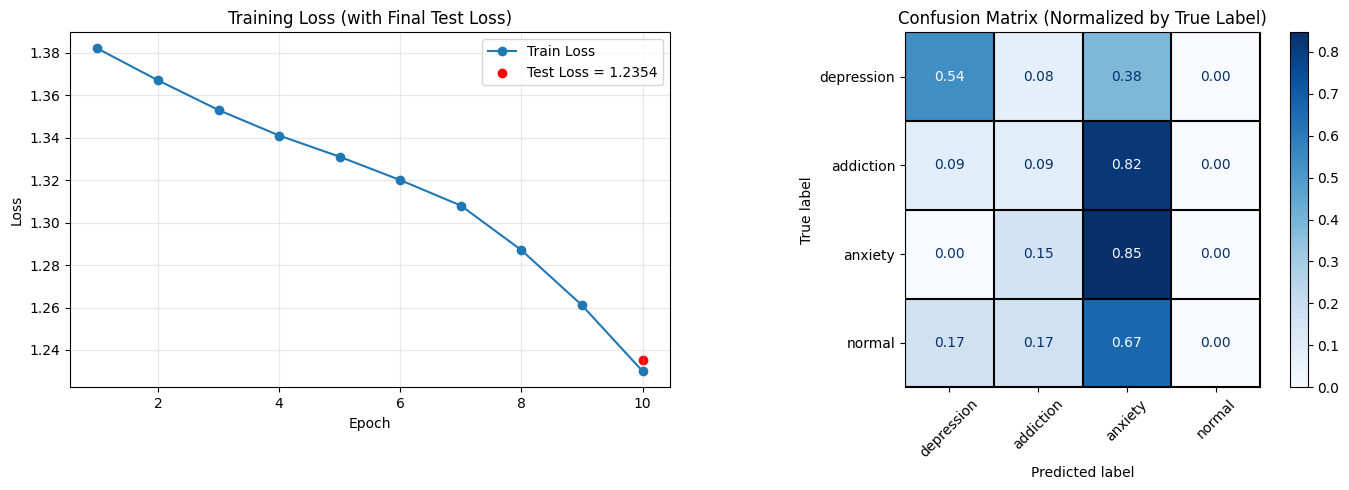

In [30]:


# ----------------------------
train_losses = train_result["train_loss"]                 # epoch별 기록(list)
test_loss = test_metrics.get("loss", None)                # 최종 test loss (있으면 표시)
y_true = np.array(test_metrics["y_true"])
y_pred = np.array(test_metrics["y_pred"])



# ----------------------------
# 1) Class names (네 설명 반영: 3=normal)
# ----------------------------
labels = [0, 1, 2, 3]
label_names = ["depression", "addiction", "anxiety", "normal"]  # 원하는 이름으로 바꿔도 됨

# ----------------------------
# 2) Make one figure with 2 panels
# ----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ---- (A) Loss curve ----
epochs = np.arange(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, marker="o", label="Train Loss")

if test_loss is not None:
    test_loss = float(test_loss)
    ax1.scatter(x = 10, y=test_loss, marker='o', color = 'red', label=f"Test Loss = {test_loss:.4f}")

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss (with Final Test Loss)")
ax1.grid(True, alpha=0.3)
ax1.legend()

# ---- (B) Confusion matrix ----
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=labels,
    normalize="true"    # 🔥 행 기준 비율 (각 클래스의 정답률)
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_names
)

disp.plot(
    ax=ax2,
    cmap="Blues",
    colorbar=True,
    values_format=".2f",   # 🔥 비율 표시
    xticks_rotation=45
)

# ----------------------------
# 셀 경계선 강조
# ----------------------------
n_classes = cm.shape[0]
for i in range(n_classes + 1):
    ax2.axhline(i - 0.5, color="black", linewidth=1.5)
    ax2.axvline(i - 0.5, color="black", linewidth=1.5)

ax2.set_title("Confusion Matrix (Normalized by True Label)")

plt.tight_layout()
plt.show()


# 확인 부분

In [23]:
# 환자의 수 파악
"""
1) text/label의 길이가 같아야 함
- getitem에서 같은 index로 둘을 동시에 꺼냄

2) label이 숫자인지 파악

3) label이 0부터 시작하는지 파악
"""

print(len(train_texts), len(train_labels), set(train_labels), train_labels.dtype)
print("--"*50)
print(len(test_texts), len(test_labels), set(test_labels), test_labels.dtype)

185 185 {0, 1, 2, 3} int64
----------------------------------------------------------------------------------------------------
24 24 {0, 1, 2, 3} int64


In [26]:
confirm_train = RNNDataset(train_texts, train_labels)
confirm_test = RNNDataset(test_texts, test_labels)


print(f'train에 들어있는 토큰의 갯수 : {confirm_train.tokenizer.vocab_size}')
print(f'test에 들어있는 토큰의 갯수 : {confirm_test.tokenizer.vocab_size}')

'''
- train, test모두 klue/bert-base에 있는 토큰을 가져다 씀
- 32,000개의 토큰수가 같음
- input_ids, attention_mask : 원본 text에서 파생. max_len에 의해 강제적으로 길이제한


'''

print('='*50)
print('하나의 샘플로 확인')
sample = confirm_train[0]
print(sample.keys())
print(f"max_len 과 같은지 : {sample['input_ids'].shape}")
print(f"max_len 과 같은지 : {sample['attention_mask'].shape}")
print(f"max_len 과 같은지 : {sample['labels'].shape}")
print('='*50)
sample1 = confirm_train[0]
print(sample1.keys())
print(f"max_len 과 같은지 : {sample1['input_ids'].shape}")
print(f"max_len 과 같은지 : {sample1['attention_mask'].shape}")
print(f"max_len 과 같은지 : {sample1['labels'].shape}")



train에 들어있는 토큰의 갯수 : 32000
test에 들어있는 토큰의 갯수 : 32000
하나의 샘플로 확인
dict_keys(['input_ids', 'attention_mask', 'labels'])
max_len 과 같은지 : torch.Size([256])
max_len 과 같은지 : torch.Size([256])
max_len 과 같은지 : torch.Size([])
dict_keys(['input_ids', 'attention_mask', 'labels'])
max_len 과 같은지 : torch.Size([256])
max_len 과 같은지 : torch.Size([256])
max_len 과 같은지 : torch.Size([])


In [31]:
batch_train = next(iter(train_loader))
batch_test = next(iter(test_loader))

'''
1) 배치와 max_len 의미
- 배치가 32 : 1 배치안에 문장이 32개가 있다
- 각 문장은 256개의 토큰으로 이루어져 있다
- 모든 배치를 묶으면 1 epoch이다

'''

print(batch_train.keys())
print(batch_train['input_ids'].shape)
print(batch_train['labels'].shape)
print(batch_train['attention_mask'].shape)

print('='*50)
print(batch_test.keys())
print(batch_test['input_ids'].shape)
print(batch_test['labels'].shape)
print(batch_test['attention_mask'].shape)

dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([32, 256])
torch.Size([32])
torch.Size([32, 256])
dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([24, 256])
torch.Size([24])
torch.Size([24, 256])
